In [2]:
import glob
from func import *
import pandas as pd
import csv
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests
import sys 
sys.path.append("..") 
sys.path.append("../scripts")
from utils import *
from scripts import process_ptb, process_ctb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 


# Response Process
If you obtain the annotations from treebanks, you can process the raw data by the scripts in this section.

Or you can replicate our results by using our processed data, which can be directly used in the **visualization** section.

## ChatGPT

In [ ]:
def compute_explained_ratio(total_phrase):

    total_node_type = []
    total_parent_type = []
    for phrase_sent in total_phrase:
        node_lst = []
        parent_lst = []
        for item in phrase_sent:
            demon_info = item[-1]
            demon = demon_info[2]
            demon_feature = cons_feature_dict[demon]
            demon_label_cons = demon_info[0]
            demon_node = demon_label_cons.split('-')[0]
            demon_parent = demon_feature[-2][demon_label_cons][-1].split('-')[0]

            cons_feature = cons_feature_dict[item[0]]
            for test_label_cons in item[2]:
                node_lst.append([demon_node, test_label_cons.split('-')[0]])
                parent_lst.append([demon_parent, cons_feature[-2][test_label_cons][-1].split('-')[0]])

        total_node_type.append(node_lst)
        total_parent_type.append(parent_lst)

    return total_node_type, total_parent_type

result_lst = []
for lang in ['english', 'chinese']:
    total_result = []
    paths = glob.glob(f"result/{lang}/chatgpt/*.csv")
    for p in paths:
        result = []
        resp_file = pd.read_csv(p,
                        delimiter='\t',
                        quoting=csv.QUOTE_NONE,
                        quotechar=None,)
        for idx, row in resp_file.iterrows():
            result.append(row.tolist()[:-1] + [row.tolist()[-1].split('/')[:-1]])
        total_result.append(result)
    result_lst.append(total_result)

# constituent rate
res_lst = []
for idx, lang in enumerate(['english', 'chinese']):
    if 'lang' == 'chinese':
        label_dict = load_label_dict('chinese')
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
    else:
        label_dict = load_label_dict('english')
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
    total_result = result_lst[idx]
    model_type = 'GPT-3.5-turbo-azure'
    total_phrase = []
    total_word = []
    total_char = []
    total_fail = []
    total_sent = []
    for result in total_result:

        if lang == 'chinese':
            phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict)
            total_char.append(char_sent)
        else:
            phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict)
            total_char.append(mixed_sent)
            assert len(mixed_sent) == 0
        total_sent.append(result)
        total_phrase.append(phrase_sent)
        total_word.append(word_sent)
        total_fail.append(fail_sent)
    phrase_level_lst = []
    word_level_lst = []
    char_level_lst = []
    fail_rate_lst = []
    
    for result, phrase_sent, \
        word_sent, char_sent, fail_sent in zip(total_sent, total_phrase, 
                                               total_word, total_char, total_fail):
        # print(len(result))
        assert len(result) == 24
        phrase_level_lst.append(len(phrase_sent) / len(result))
        word_level_lst.append(len(word_sent) / len(result))
        char_level_lst.append(len(char_sent) / len(result))
        fail_rate_lst.append(len(fail_sent) / len(result))
        
    res_lst.append([phrase_level_lst, word_level_lst, fail_rate_lst, char_level_lst])
gpt_constituent_rate = res_lst

# explained ratio
model_plot_lst = []
for idx, lang in enumerate(['english', 'chinese']):
    if 'lang' == 'chinese':
        label_dict = load_label_dict('chinese')
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
    else:
        label_dict = load_label_dict('english')
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        
    total_phrase = []
    total_sent = []
    total_result = result_lst[idx]
    for result in total_result:
        xp_result = []
        for res in result:
            demon_info = res[-1]
            cons_feature = cons_feature_dict[res[0]]
            xp_result.append(res)
        demon_lst = [item[-1] for item in xp_result]
        xp_result = [item[:-1] for item in xp_result]
        if lang == 'chinese':
            phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(xp_result, cons_feature_dict, demon_lst)
        else:
            phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(xp_result, cons_feature_dict, demon_lst)
        total_sent.append(xp_result)
        total_phrase.append(phrase_sent)


    
    (total_test_node_type, 
    total_test_parent_type) = compute_explained_ratio(total_phrase)


    # for VP-XP-NP
    model_plot = [[] for _ in range(len(total_test_node_type))]
    for idx, (test_node, test_parent) in enumerate(zip(total_test_node_type, 
                                                        total_test_parent_type)):
        
        total = 0
        node_rate = 0
        parent_rate = 0
        for node, parent in zip(test_node, test_parent):

            if node[0] == node[1] and parent[0] == parent[1]:
                continue
            if node[0] == node[1]:
                node_rate += 1
            if parent[0] == parent[1]:
                parent_rate += 1
            total +=1

        node_rate = node_rate / total
        parent_rate = parent_rate/ total

        model_plot[idx].extend([ node_rate, parent_rate])
    model_plot_lst.append(model_plot)
gpt_explained_ratio = model_plot_lst

## Native speaker

In [ ]:
def process_human_result(paths):
    result_lst =[]
    for p in paths:

        res_file = pd.read_csv(p,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            quotechar=None,
                            error_bad_lines=False)
        result = []
        demon = []
        for index, row in res_file.iterrows():
            orig = row['original']
            pred = row['prediction']
            if pd.isna(pred):
                result.append([orig, label_dict[orig][0], 'fail to follow'])
                demon.append(row['group'])
                continue
            pred = re.sub(r'\W', ' ', pred)
            pred = pred.split(' ')
            pred = list(filter(lambda x: x and x.strip(), pred))
            pred = ' '.join(pred)
            if orig == pred:
                pred = 'fail to follow'
            if not set(pred.lower().split(' ')).issubset(set(orig.lower().split(' '))) :
                pred = 'fail to follow'
            
            result.append([orig, label_dict[orig][0], pred])
            demon.append(row['group'])

        total_result = []
        for res, d in zip(result, demon):
            total_result.append(res + [d])
        result_lst.append(total_result)

    if 'chinese' in paths[0]:
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
        label_dict = load_label_dict('chinese')
        label_path = 'stimulus/chinese.csv'
    else:
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        label_dict = load_label_dict('english')
        label_path = 'stimulus/english.csv'
    constituent_rate = []
    for result in result_lst:
        demon = [item[-1] for item in result]
        result = [item[:-1] for item in result]
        if 'ctb' in paths[0]:
            phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict)
            constituent_rate.append([len(phrase_sent) / len(result),
                            len(word_sent) / len(result),
                            len(fail_sent) / len(result),
                            len(char_sent) / len(result)])
        else:
            phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict, demon)

            constituent_rate.append([len(phrase_sent) / len(result),
                            len(word_sent) / len(result),
                            len(fail_sent) / len(result)])
    

    label_dict = {}
    label_file = pd.read_csv(label_path,
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    for row_idx, row in label_file.iterrows():
        label_dict[(row['demonstration'], row['test'])] = [row['demon_label'], row['demon_cons'], row['demon_parent']]

    total_phrase = []
    for result in result_lst:
        
        demonstrations = [item[-1] for item in result]
        result = [item[:-1] for item in result]
        if 'chinese' in paths[0]:
            phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict, demon = demonstrations)
        else:
            phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict, demon = demonstrations)
        total_phrase.append(phrase_sent)

    total_node_type_lst = []
    total_parent_type_lst = []

    for phrase_sent in total_phrase:
        node_type_lst = []
        parent_type_lst = []

        for item in phrase_sent:

            demon = item[-1]
            test_sent = item[0]
            label_info = label_dict[(demon, test_sent)]
            demon_feature = cons_feature_dict[demon]
            demon_label_cons = label_info[1]

            cons_feature = cons_feature_dict[test_sent]
            demon_node = demon_label_cons.split('-')[0]
            demon_parent = demon_feature[-2][demon_label_cons][-1].split('-')[0]
            for test_label_cons in item[2]:
                node_type_lst.append([demon_node, test_label_cons.split('-')[0]])
                parent_type_lst.append([demon_parent, cons_feature[-2][test_label_cons][-1].split('-')[0]])
        
        total_node_type_lst.append(node_type_lst)
        total_parent_type_lst.append(parent_type_lst)
    node_rate_lst = []
    parent_rate_lst = []
    for node_lst, parent_lst in zip(total_node_type_lst, total_parent_type_lst):
        node_rate = 0
        parent_rate = 0
        total = 0
        for node, parent in zip(node_lst, parent_lst):
            if node[0] == node[1] and parent[0] == parent[1]:
                continue
            if node[0] == node[1]:
                node_rate += 1
            if parent[0] == parent[1]:
                parent_rate += 1
            total += 1
        # print(total)
        node_rate_lst.append(node_rate / total)
        parent_rate_lst.append(parent_rate / total)
    explained_ratio = []
    for idx,(node_rate, parent_rate) in enumerate(zip(node_rate_lst, parent_rate_lst)):
        explained_ratio.append([node_rate, parent_rate])

    return constituent_rate, explained_ratio
en_native_paths = glob.glob('result/english/native/*.csv')
zh_native_paths = glob.glob('result/chinese/native/*.csv')

en_native_constituent_rate, en_native_explained_ratio = process_human_result(en_native_paths)
zh_native_constituent_rate, zh_native_explained_ratio = process_human_result(zh_native_paths)


# Visualization

## Constituent rate

/tmp/ipykernel_335080/3852269245.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax,


[3 3 3 3]


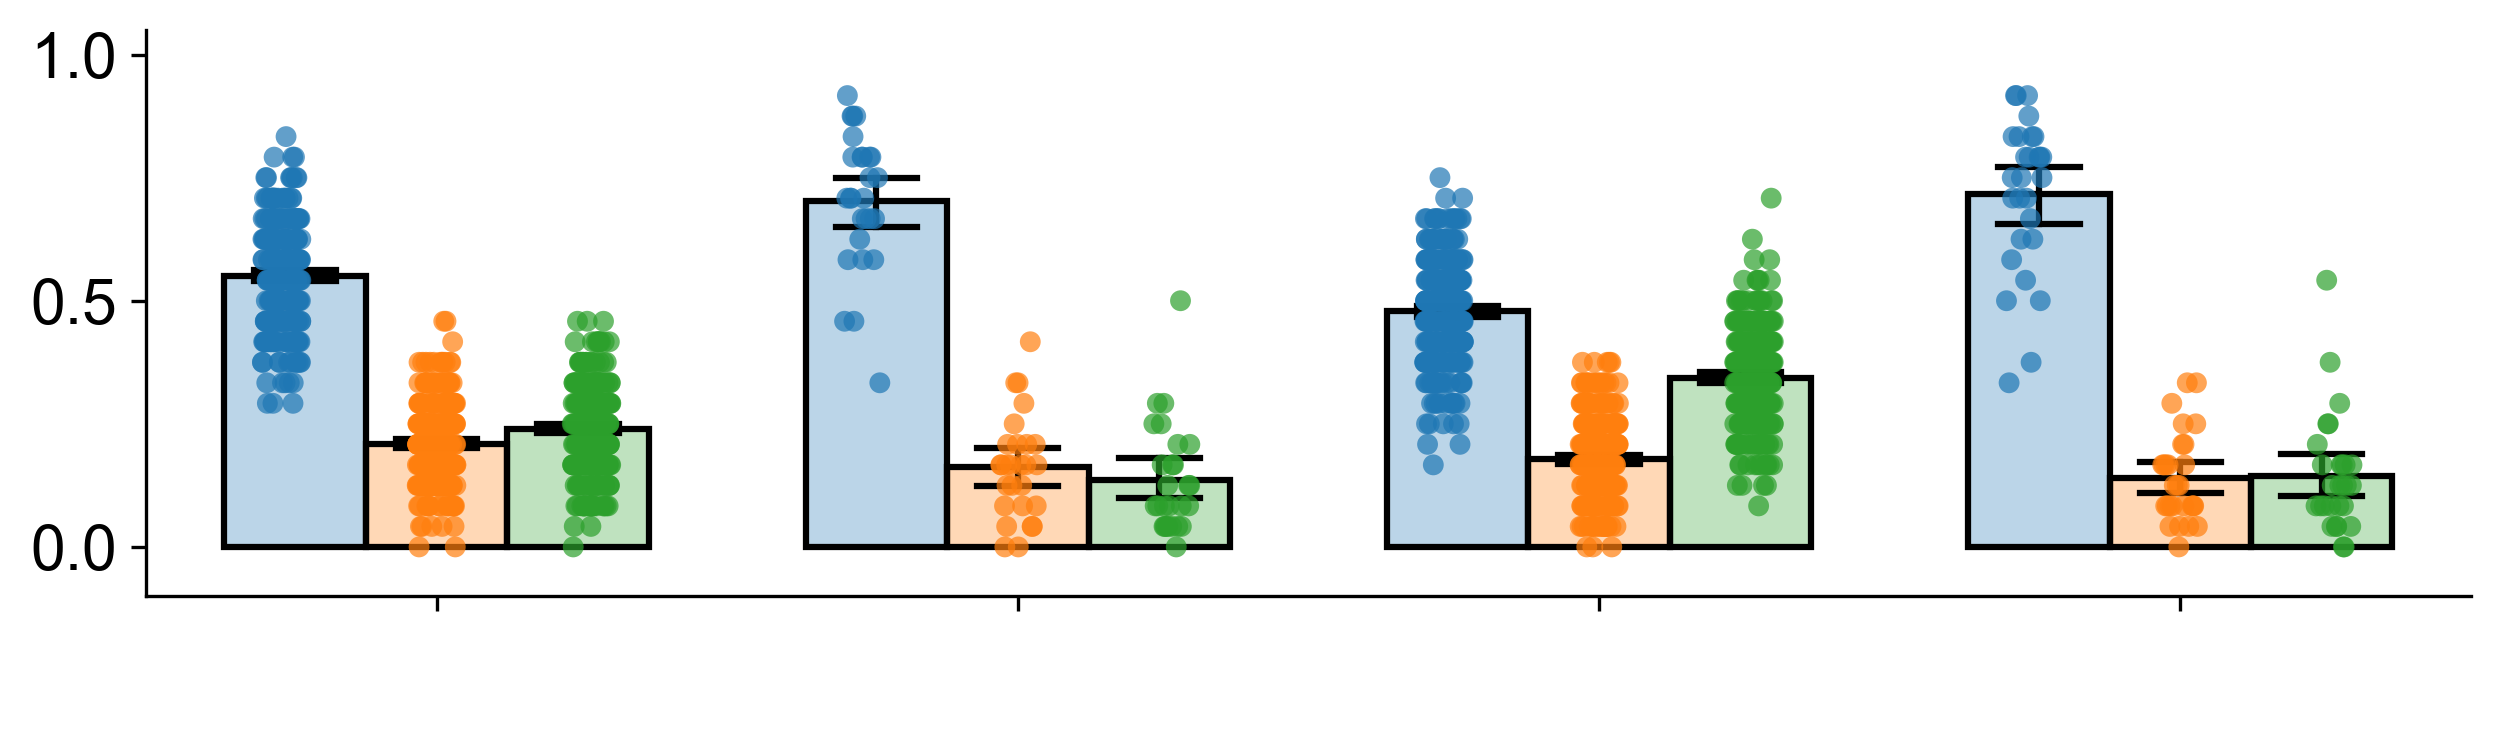

In [ ]:
plt.rcParams['font.size'] = 15

processed_data = read_pkl('processed_data/constituent_rate.pkl')
df = processed_data[0]
fig, ax = plt.subplots(1, 1 , figsize=(10,2.5))
sns.set_context(rc = {'patch.linewidth': 1.5})

df = pd.DataFrame.from_dict(df)

palette = {
    'phrase': '#1f77b4',
    'word': '#ff7f0e',
    'other': '#2ca02c'
}


g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax, 
                palette=palette,
                errorbar = ('ci', 95),  
                estimator=np.mean, ci=95, capsize=.14, 
                errwidth=1.5, errcolor = 'k', 
                edgecolor =  (0,0,0,1), width=0.73
                )
hue_nums = df.groupby("class")["type"].nunique().values

color_lst = ['#1f77b4',
    '#ff7f0e',
    
    '#2ca02c',
    '#d62728',]


for i, bar in enumerate(g.patches):
    x_category = np.repeat(np.arange(len(hue_nums)), len(hue_nums))[i]
    hue_category = np.tile(np.arange(max(hue_nums)), len(hue_nums))[i]
    color = color_lst[x_category]
    bar.set_facecolor(to_rgba(color, 0.3))
    bar.set_edgecolor((0, 0, 0, 1))
    
g = sns.stripplot(
    data = df,
    x="class", 
    y="value", 
    hue="type", 
    dodge=True, 
    alpha=0.7,
    edgecolor=None, 
    ax=ax
)

plt.ylim([-0.0,1.05])
sns.despine(top=True, right=True, left=False, bottom=False)
g.set(ylabel='')
g.set(xlabel='  ')

g.set(ylim=[-0.1,1.05])
g.set(ylabel='Proportion')
g.set(xlabel='  ')
g.set(xticklabels=[])

hatches = ['', '', '', '']*3

for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])

plt.ylabel("")
plt.xlabel(r"   ")

plt.legend([],[], frameon=False)


## Constituent rate of GPT-2

/tmp/ipykernel_335080/4026972010.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(xlim=[0,5000])
/tmp/ipykernel_335080/4026972010.py:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(xlim=[0,5000])


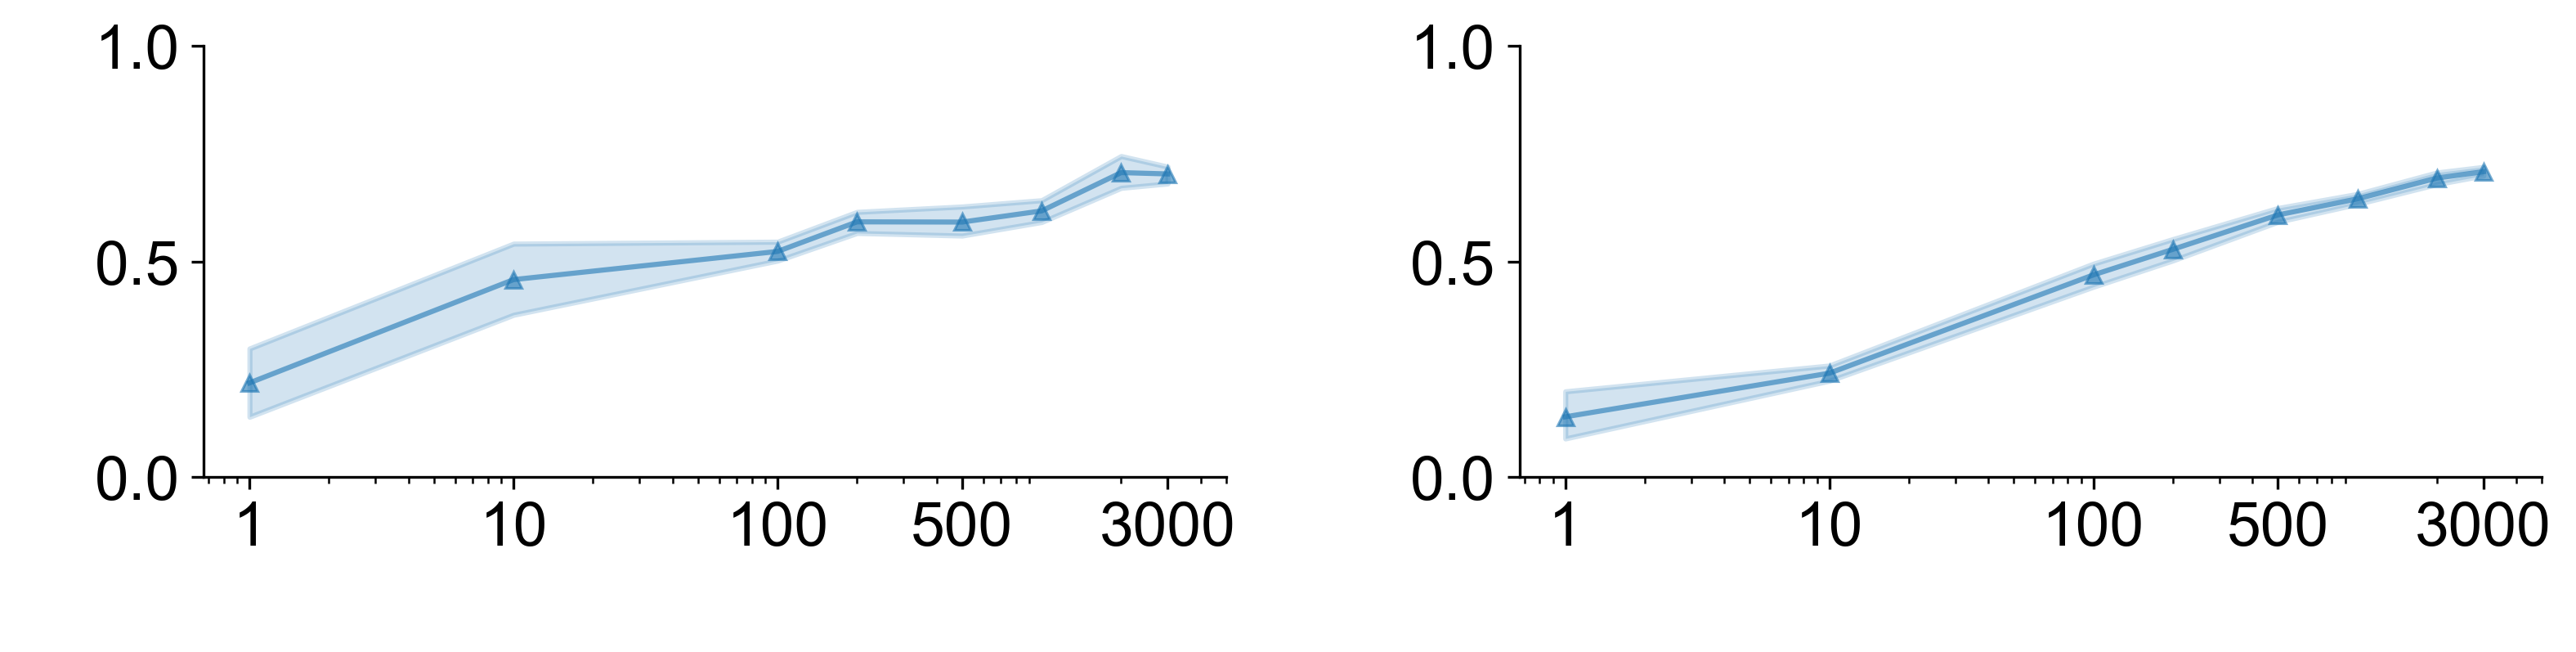

In [3]:
plt.rcParams['font.size'] = 18

fig, axes = plt.subplots(1, 2,figsize=(11,3))
sns.despine(top=True, right=True, left=False, bottom=False)

df = read_pkl('processed_data/constituent_rate_gpt-2.pkl')

data = df[df['lang'] == 'en']
g = sns.lineplot(x="n_sample", y="phrase", data=data, 
                 marker="^", errorbar=('ci', 95),
                markersize=5, markeredgecolor=None, ax=axes[0], alpha=0.6,
                )


g.set(xscale='log')
g.set(xticks=[1,10,100,500,3000])
g.set(xticklabels=[1,10,100,500,3000])
g.set(ylim=(0,1))
g.set(xlim=[0,5000])
g.set(xlabel='  ')
g.set(ylabel='  ')
axes[0].legend([],[], frameon=False)

data = df[df['lang'] == 'zh']
g = sns.lineplot(x="n_sample", y="phrase", data=data, 
                 marker="^", errorbar=('ci', 95),
                markersize=5, markeredgecolor=None, ax=axes[1], alpha=0.6,
                )

g.set(xscale='log')
g.set(xticks=[1,10,100,500,3000])
g.set(xticklabels=[1,10,100,500,3000])
g.set(ylim=(0,1))
g.set(xlim=[0,5000])
g.set(xlabel='  ')
g.set(ylabel='  ')
axes[1].legend([],[], frameon=False)
plt.tight_layout()

## Explained ratio

model-en significance test, original:  0.00019998000199980003 FDR corrected:  0.00019998000199980003
human-en significance test, original:  0.00019998000199980003 FDR corrected:  0.00019998000199980003
model-zh significance test, original:  0.00019998000199980003 FDR corrected:  0.00019998000199980003
human-zh significance test, original:  0.00019998000199980003 FDR corrected:  0.00019998000199980003


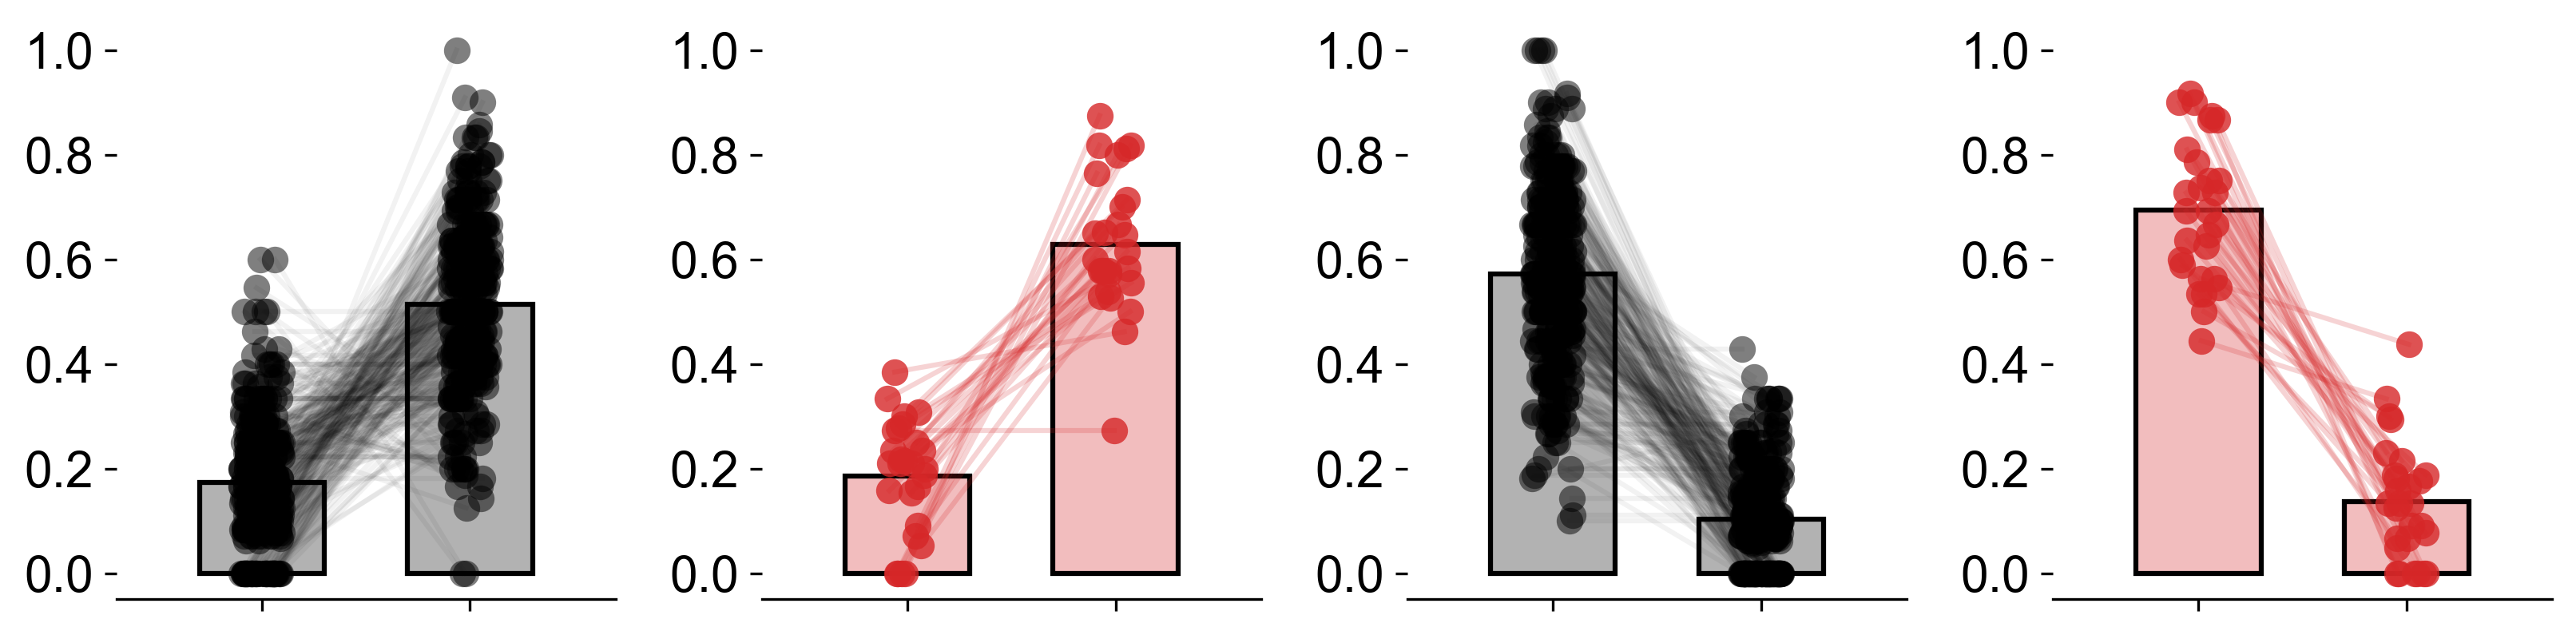

In [3]:

fig, axes = plt.subplots(1,4, figsize=(11,2.9))
sns.despine(top=True, right=True, left=True, bottom=False)
pvals =[]
sns.set_context(rc = {'patch.linewidth': 1.5})
df = read_pkl('processed_data/explained_ratio.pkl')
model_lst = ['model-en', 'human-en', 'model-zh', 'human-zh']
for idx, (ax, prefix) in enumerate(zip(axes, model_lst,)):
    plot_df = df[df.iloc[:,0].str.contains(prefix + '_')]
    palette = {
        'model-en': 'k',
        'model-zh': 'k',
        'human-en': '#d62728',
        'human-zh': '#d62728',
    }

    color = palette[prefix]

    g = sns.barplot(data = plot_df, x='subj', y='value', ax=ax, 
                    color=color,
                    errorbar = None,  
                    capsize=.1, 
                    width=0.6,
                    edgecolor = (0,0,0,1),
                    )
    for i, bar in enumerate(g.patches):
        color = color
        bar.set_facecolor(to_rgba(color, 0.3))
        bar.set_edgecolor((0, 0, 0, 1))
    if 'model' in prefix:
        alpha = 0.5
    else:
        alpha=0.8
    g = sns.stripplot(data=plot_df, x='subj', y='value', ax=ax, 
                      size=8, color=color, edgecolors='k', alpha=alpha)

    a = ax.scatter([1,2],[3,4], marker='o')
    b = ax.scatter([1,2],[3,4], marker='o')

    square_mk, = a.get_paths()
    triangle_up_mk, = b.get_paths()
    a.remove()
    b.remove()
    N_hues = len(pd.unique(plot_df.subj))

    c = ax.collections
    for a in c[::N_hues]:
        a.set_paths([triangle_up_mk])
    for a in c[1::N_hues]:
        a.set_paths([square_mk])
    #update legend
    ax.legend(c[-2:],pd.unique(plot_df.subj))


    set1 = plot_df[plot_df['subj'] == prefix+'_node']['value'].tolist()
    set2 = plot_df[plot_df['subj'] == prefix+'_parent']['value'].tolist()
    pvals.append([prefix, paired_bootstrap_test(set1, set2)])


    idx0 = 2
    idx1 = 3
    locs1 = ax.get_children()[idx0].get_offsets()
    locs2 = ax.get_children()[idx1].get_offsets()


    sort_idxs1 = np.argsort(set1)
    sort_idxs2 = np.argsort(set2)


    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    locs2_sorted = locs2
    if 'model' in prefix:
        alpha = 0.05
    else:
        alpha=0.2
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2_sorted[i, 0]]
        y = [locs1[i, 1], locs2_sorted[i, 1]]
        ax.plot(x, y, color=color, alpha=alpha)
    g.set(xlim=[-0.7,1.7])
    g.set(ylim=[-0.05, 1.05])
    g.set(yticks=[0,0.2,0.4,0.6,0.8,1.0])
    g.set(ylabel='')
    g.set(xlabel='')
    g.set(xticklabels='')

    ax.legend([],[], frameon=False)
plt.tight_layout()

reject, pvals_corrected, _, _ = multipletests([p[1] for p in pvals], alpha=0.05, method='fdr_bh')
for p, corrected_p in zip(pvals, pvals_corrected):
    print(p[0], 'significance test, original: ', p[1], 'FDR corrected: ', corrected_p)



## Explained ratio of GPT-2

/tmp/ipykernel_437462/4086529017.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(xlim=[0,5000])
/tmp/ipykernel_437462/4086529017.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(xlim=[0,5000])


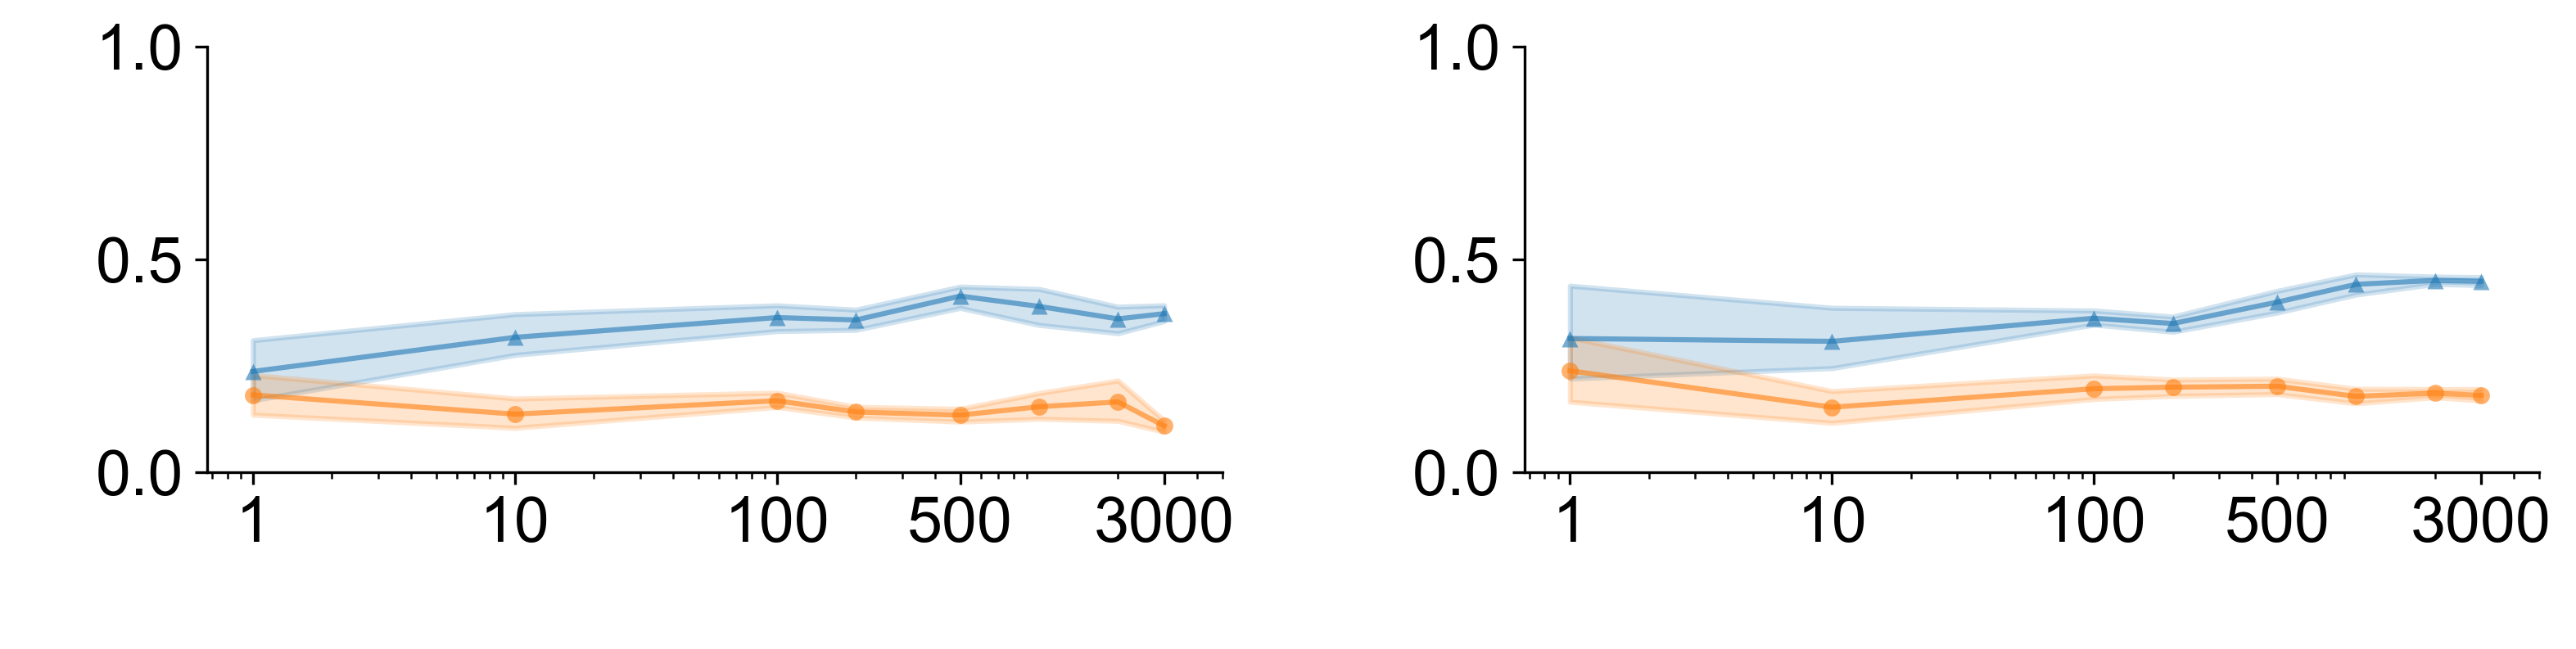

In [4]:
plt.rcParams['font.size'] = 18.5


df = read_pkl("processed_data/explained_ratio_gpt-2.pkl")
fig, axes = plt.subplots(1, 2,figsize=(11,3))
sns.despine(top=True, right=True, left=False, bottom=False)

data = df[df['lang'] == 'en']

g = sns.lineplot(x="n_sample", y="value", hue='type', data=data, 
                style='type', 
                markers=['^','o'],
                dashes= False,
                markersize=5, markeredgecolor='None', ax=axes[0], alpha=0.6,
                )

g.set(xscale='log')
g.set(xticks=[1,10,100,500,3000])
g.set(xticklabels=[1,10,100,500,3000])
g.set(ylim=(0,1))
g.set(xlim=[0,5000])
axes[0].legend([],[], frameon=False)
g.set(xlabel='  ')
g.set(ylabel='  ')


data = df[df['lang'] == 'zh']

g = sns.lineplot(x="n_sample", y="value", hue='type', data=data, 
                style='type', 
                markers=['^','o'],
                dashes= False,
                markersize=5, markeredgecolor='None', ax=axes[1], alpha=0.6,
                )

g.set(xscale='log')
g.set(xticks=[1,10,100,500,3000])
g.set(xticklabels=[1,10,100,500,3000])
g.set(ylim=(0,1))
g.set(xlim=[0,5000])
axes[1].legend([],[], frameon=False)
g.set(xlabel='  ')
g.set(ylabel='  ')
plt.tight_layout()

# Discrimination Analysis

## Metrics calculation

In [2]:
from func import random_deletion
result_lst = []
for lang in ['english','chinese',]:
    for subj in ['chatgpt', 'native']:

        total_result = []
        paths = glob.glob(f"result/{lang}/{subj}/*.csv")
        for p in paths:
            result = []
            resp_file = pd.read_csv(p,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            quotechar=None,)
            for idx, row in resp_file.iterrows():
                result.append(row.tolist())
            total_result.append(result)
        result_lst.append(total_result)


total_resp = []
for lst in result_lst:
    for result in lst:
        total_resp.extend([(r[0], r[1].lower()) for r in result])

nonsubj_result_lst = []
for lst in result_lst:
    lst_tmp = []
    for result in lst:
        result_tmp = []
        for r in result:
            while True:
                random_r = random_deletion([r[0]], 1)[0][0]
                if (random_r[0], random_r[2].lower()) not in total_resp:
                    break
            result_tmp.append(random_r + [r[-1]])
        lst_tmp.append(result_tmp)
    nonsubj_result_lst.append(lst_tmp)


In [ ]:
from func import *
from tqdm import tqdm
        
subj_feature = []
for idx, lst in enumerate(result_lst):
    subj_lst = []
    if idx in [0, 2]:
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ptb_dep_feature.pkl')
        label_dict = load_label_dict('english')
        is_ctb = False
        # continue
    else:
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ctb_dep_feature.pkl')
        label_dict = load_label_dict('chinese')
        is_ctb = True
        
    for result in lst:
        linear_feature_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)
        
        dep_feature_lst, mdd_lst = get_dependency_feature(result, dep_feature_dict, is_ctb)
        cons_feature_lst = get_constituent_feature(result, cons_feature_dict, is_ctb)
        subj_lst.append([linear_feature_lst, dep_feature_lst, mdd_lst, cons_feature_lst])
    subj_feature.append(subj_lst)

nonsubj_feature = []
for idx, lst in enumerate(nonsubj_result_lst):
    subj_lst = []
    if idx in [0, 2]:
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ptb_dep_feature.pkl')
        label_dict = load_label_dict('english')
        is_ctb = False
    else:
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ctb_dep_feature.pkl')
        label_dict = load_label_dict('chinese')
        is_ctb = True
    for i, result in enumerate(tqdm(lst)):

        linear_feature_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)
        dep_feature_lst, mdd_lst = get_dependency_feature(result, dep_feature_dict, is_ctb)
        cons_feature_lst = get_constituent_feature(result, cons_feature_dict, is_ctb)
        subj_lst.append([linear_feature_lst, dep_feature_lst, mdd_lst, cons_feature_lst])
    nonsubj_feature.append(subj_lst)
    
    

In [ ]:
from scripts.process_ctb import ctb_dependency_analysis_keep, ctb_constituent_analysis_keep
from scripts.process_ptb import ptb_dependency_analysis_keep, ptb_constituent_analysis_keep
from scripts.process_ctb import get_spans_from_chinese_sentence
from scripts.process_ptb import get_spans_from_sentence
from tqdm import tqdm


model_lst = ['model-en',
    'model-zh',
    'human-en',
    'human-zh'
    ]

subj_tmp = []
for name, subj_f, r_lst_raw in zip(model_lst, subj_feature, result_lst):
    if 'zh' in name:
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ctb_dep_feature.pkl')
        label_dict = load_label_dict('ellipsis_ctb_vpnp_filtered_syntax')
        is_ctb = True
    else:
        
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ptb_dep_feature.pkl')
        label_dict = load_label_dict('ellipsis_vpnp_syntax')
        is_ctb = False

    tmp_lst = []
    for f_lst, result_raw in tqdm(zip(subj_f, r_lst_raw)):
        result = [[item[0], item[0], item[1], r[3]] for item, r in zip(f_lst[0], result_raw)]
        remained_cons_lst = []
        for r in result:
            if '##' in r[2] or r[2] == 'fail to follow':
                remained_cons_lst.append([r[0], r[2], 'other'])
                continue
            if is_ctb:
                if not set(r[2]).issubset(set(r[0])):
                    print(r)
                    remained_cons_lst.append([r[0], r[2], 'other'])
                    continue
                span_lst = get_spans_from_chinese_sentence(r[0], r[2])
                span_lst = [[r[0], r[1], s] for s in span_lst]
                phrase_sent, word_sent, char_sent, fail_sent = ctb_constituent_analysis_keep(span_lst, cons_feature_dict)
                other_sent = fail_sent + char_sent
            else:
                if not set(r[2].lower().split(" ")).issubset(set(r[0].lower().split(" "))):
                    remained_cons_lst.append([r[0], r[2], 'other'])
                    continue
                span_lst = get_spans_from_sentence(r[0], r[2])
                span_lst = [[r[0], r[1], s] for s in span_lst]
                phrase_sent, mixed_sent, word_sent, fail_sent = ptb_constituent_analysis_keep(span_lst, cons_feature_dict)
                other_sent = fail_sent
                assert len(mixed_sent) == 0
            if not is_ctb:
                assert len(other_sent) == 0

            remained_cons_lst.append([r[0], r[2], ['constituent']*len(phrase_sent) + ['nonconstituent']*(len(word_sent) + len(other_sent))])
        if is_ctb:
            phrase_sent, word_sent, fail_sent = ctb_dependency_analysis_keep(result, dep_feature_dict)
            other_sent = fail_sent
        else:
            phrase_sent, word_sent, fail_sent = ptb_dependency_analysis_keep(result, dep_feature_dict)
            other_sent = fail_sent
            assert len(mixed_sent) == 0
        phrase_sent = [(item[0], item[1].lower()) for item in phrase_sent]
        word_sent = [(item[0], item[1].lower()) for item in word_sent]
        other_sent = [(item[0], item[1].lower()) for item in other_sent]
        remained_dep_lst = []
        for r in result:
            if (r[0], r[2].lower()) in phrase_sent:
                remained_dep_lst.append([r[0], r[2], 'connected'])
            elif (r[0], r[2].lower()) in word_sent:
                remained_dep_lst.append([r[0], r[2], 'disconnected'])
            else:
                remained_dep_lst.append([r[0], r[2], 'other'])

        # mdd difference
        demon_mdd_lst = []
        new_mdd = get_mdd_lst(result, dep_feature_dict, is_ctb)
        for r, mdd_lst in zip(result, new_mdd):

            label_info = label_dict[r[-1]]
            cons_feature = cons_feature_dict[r[-1]]
            demon_remained = label_info[0]
            demon = r[-1]
            if '##' in r[2] or r[2] == 'fail to follow':
                demon_mdd_lst.append([demon, demon_remained, -1, -1])
                continue
            if is_ctb:
                orig = list(demon.strip())
                n_op, ops = minDeletionops(orig, list(demon_remained.strip()))
            else:
                orig = demon.split(' ')
                orig = list(filter(lambda x: x and x.strip(), orig))
                orig = ' '.join(orig).lower().split(' ')
                n_op, ops = minDeletionops(orig, demon_remained.lower().split(' '))
            deleted_idx = [item[0] for item in ops]
            deleted = []
            remained = []
            for idx, tok in enumerate(orig):
                if idx in deleted_idx:
                    deleted.append([idx, tok])
                else:
                    remained.append([idx, tok])
            dep_feature = dep_feature_dict[r[-1]]
            if is_ctb:
                tok_lst = list(dep_feature.keys())
                tok_lst = sorted(tok_lst, key = lambda x: x[0])
                deleted = merge_char_to_word(deleted, tok_lst)
                remained = merge_char_to_word(remained, tok_lst)

            mdd_d = get_mean_dependency_distance(deleted, dep_feature)
            mdd_r = get_mean_dependency_distance(remained, dep_feature)
            demon_mdd_lst.append([demon, demon_remained, mdd_lst[2] - mdd_d, mdd_lst[3] - mdd_r])
        
        abs_linear_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)
        linear_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)

        tmp_lst.append([f_lst[3], remained_cons_lst, f_lst[1], remained_dep_lst,
                        new_mdd, demon_mdd_lst, abs_linear_lst, linear_lst])

    subj_tmp.append(tmp_lst)
subj_feature = subj_tmp

nonsubj_tmp = []
for name, subj_f, r_lst_raw in zip(model_lst, nonsubj_feature, result_lst):
    if 'zh' in name:
        cons_feature_dict = read_pkl('data/ctb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ctb_dep_feature.pkl')
        label_dict = load_label_dict('ellipsis_ctb_vpnp_filtered_syntax')
        is_ctb = True
    else:
        cons_feature_dict = read_pkl('data/ptb_cons_feature.pkl')
        dep_feature_dict = read_pkl('data/ptb_dep_feature.pkl')
        label_dict = load_label_dict('ellipsis_vpnp_syntax')
        is_ctb = False
    tmp_lst = []
    for f_lst, result_raw in tqdm(zip(subj_f, r_lst_raw)):
        result = [[item[0], item[0], item[1].lower(), r[3]] for item, r in zip(f_lst[0], result_raw)]
        
        # remained cons
        remained_cons_lst = []
        for r in result:
            if '##' in r[2] or r[2] == 'fail to follow':
                remained_cons_lst.append([r[0], r[2], 'other'])
                continue
            if is_ctb:
                if not set(r[2]).issubset(set(r[0])):
                    remained_cons_lst.append([r[0], r[2], 'other'])
                    continue
                span_lst = get_spans_from_chinese_sentence(r[0], r[2])
                span_lst = [[r[0], r[1], s] for s in span_lst]
                phrase_sent, word_sent, char_sent, fail_sent = ctb_constituent_analysis_keep(span_lst, cons_feature_dict)
                other_sent = fail_sent + char_sent
            else:
                if not set(r[2].lower().split(" ")).issubset(set(r[0].lower().split(" "))):

                    remained_cons_lst.append([r[0], r[2], 'other'])
                    continue
                span_lst = get_spans_from_sentence(r[0], r[2])
                span_lst = [[r[0], r[1], s] for s in span_lst]
                phrase_sent, mixed_sent, word_sent, fail_sent = ptb_constituent_analysis_keep(span_lst, cons_feature_dict)
                other_sent = fail_sent
                assert len(mixed_sent) == 0
            if not is_ctb:
                assert len(other_sent) == 0
            remained_cons_lst.append([r[0], r[2], ['constituent']*len(phrase_sent) + ['nonconstituent']*(len(word_sent) + len(other_sent))])

        if is_ctb:
            phrase_sent, word_sent, fail_sent = ctb_dependency_analysis_keep(result, dep_feature_dict)
            other_sent = fail_sent
        else:
            phrase_sent, word_sent, fail_sent = ptb_dependency_analysis_keep(result, dep_feature_dict)
            other_sent = fail_sent
            assert len(mixed_sent) == 0
        phrase_sent = [(item[0], item[1].lower()) for item in phrase_sent]
        word_sent = [(item[0], item[1].lower()) for item in word_sent]
        other_sent = [(item[0], item[1].lower()) for item in other_sent]
        remained_dep_lst = []
        for r in result:
            if (r[0], r[2].lower()) in phrase_sent:
                remained_dep_lst.append([r[0], r[2], 'connected'])
            elif (r[0], r[2].lower()) in word_sent:
                remained_dep_lst.append([r[0], r[2], 'disconnected'])
            else:
                remained_dep_lst.append([r[0], r[2], 'other'])

        # mdd difference
        demon_mdd_lst = []
        new_mdd = get_mdd_lst(result, dep_feature_dict, is_ctb)
        for r, mdd_lst in zip(result, new_mdd):

            label_info = label_dict[r[-1]]
            cons_feature = cons_feature_dict[r[-1]]
            demon_remained = label_info[0]
            demon = r[-1]
            if '##' in r[2] or r[2] == 'fail to follow':
                demon_mdd_lst.append([demon, demon_remained, -1, -1])
                continue
            if is_ctb:
                orig = list(demon.strip())
                n_op, ops = minDeletionops(orig, list(demon_remained.strip()))
            else:
                orig = demon.split(' ')
                orig = list(filter(lambda x: x and x.strip(), orig))
                orig = ' '.join(orig).lower().split(' ')
                n_op, ops = minDeletionops(orig, demon_remained.lower().split(' '))
            deleted_idx = [item[0] for item in ops]
            deleted = []
            remained = []
            for idx, tok in enumerate(orig):
                if idx in deleted_idx:
                    deleted.append([idx, tok])
                else:
                    remained.append([idx, tok])
            dep_feature = dep_feature_dict[r[-1]]
            if is_ctb:
                tok_lst = list(dep_feature.keys())
                tok_lst = sorted(tok_lst, key = lambda x: x[0])
                deleted = merge_char_to_word(deleted, tok_lst)
                remained = merge_char_to_word(remained, tok_lst)
            
            mdd_d = get_mean_dependency_distance(deleted, dep_feature)
            mdd_r = get_mean_dependency_distance(remained, dep_feature)
            demon_mdd_lst.append([demon, demon_remained, mdd_lst[2] - mdd_d, mdd_lst[3] - mdd_r])
        
        # abs length and size
        # remain onset, delete onset, remain length, delete length
        abs_linear_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)
        
        # length and size different
        # remain onset, delete onset, remain length, delete length
        linear_lst = get_linear_feautre(result, label_dict, cons_feature_dict, is_ctb)
        tmp_lst.append([f_lst[3], remained_cons_lst, f_lst[1], remained_dep_lst,
                        new_mdd, demon_mdd_lst, abs_linear_lst, linear_lst])
    nonsubj_tmp.append(tmp_lst)
nonsubj_feature = nonsubj_tmp


## SVM training

### Numerical metrics

In [10]:
subj_feature = read_pkl("processed_data/svm_subj_data.pkl")
nonsubj_feature = read_pkl("processed_data/svm_random_data.pkl")

import copy
from collections import Counter
subj_num_feature = []
for idx, subj_lst in enumerate(subj_feature):
    num_feature = []
    for s_idx, lst in enumerate(subj_lst):
        (d_cons, r_cons,
         d_dep, r_dep,
         mdd, mdd_diff,
         linear, linear_diff) = lst
        for d_c, r_c, d_d, r_d, m, m_diff,l, l_diff in zip(d_cons, r_cons,
                            d_dep, r_dep,
                            mdd, mdd_diff,
                            linear, linear_diff):
            f_lst = []
            if d_c[-1] == 'other':
                continue

            if d_c[-1] == 'constituent':
                f_lst.append(1)
            else:
                f_lst.append(0)
            r_c_count = Counter(r_c[-1])
            f_lst.append(r_c_count['constituent'] / len(r_c[-1]))

            if d_d[-1] == 'connected':
                f_lst.append(1)
            else:
                f_lst.append(0)

            if r_d[-1] == 'connected':
                f_lst.append(1)
            else:
                f_lst.append(0)

            f_lst.extend([m[-2], m[-1]])
            
            f_lst.extend([l[3], 
                          l[2], 
                          l[7], 
                          l[6], 
                          ]) 
            num_feature.append(f_lst)
    print(len(num_feature))
    subj_num_feature.append(num_feature)

nonsubj_num_feature = []
for idx, (subj_lst, ref_lst) in enumerate(zip(nonsubj_feature, subj_feature)):
    num_feature = []
    for lst, r_lst in zip(subj_lst, ref_lst):
        (d_cons, r_cons,
         d_dep, r_dep,
         mdd, mdd_diff,
         linear, linear_diff) = lst
        for d_c, r_c, d_d, r_d, m, m_diff,l, l_diff, ref_l in zip(d_cons, r_cons,
                            d_dep, r_dep,
                            mdd, mdd_diff,
                            linear, linear_diff, r_lst[0]):
            f_lst = []

            if ref_l[-1] == 'other':
                continue


            if d_c[-1] == 'constituent':
                f_lst.append(1)
            else:
                f_lst.append(0)
            r_c_count = Counter(r_c[-1])
            f_lst.append(r_c_count['constituent'] / len(r_c[-1]))

            if d_d[-1] == 'connected':
                f_lst.append(1)
            else:
                f_lst.append(0)

            if r_d[-1] == 'connected':
                f_lst.append(1)
            else:
                f_lst.append(0)

            if pd.isna(m[-2]):
                print(idx, c)
            f_lst.extend([m[-2], m[-1]])
            f_lst.extend([l[3], 
                          l[2], 
                          l[7], 
                          l[6], 
                          ])
            
            num_feature.append(f_lst)
    print(len(num_feature))

    nonsubj_num_feature.append(num_feature)

5471
560
4726
575
5471
560
4726
575


### All-metrics SVM

In [ ]:

import random
from sklearn.linear_model import LinearRegression
import numpy as np
import copy
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler

def flatten_lst(lst):
    tmp = []
    for item in lst:
        tmp.extend(item.tolist())
    return tmp


n_cv = 10

model_lst = ['model-en', 'human-en','model-zh','human-zh']
acc_lst = []
for idx, (subj_f_raw, nonsubj_f_raw) in enumerate(zip(subj_num_feature, nonsubj_num_feature)):
    print(model_lst[idx])
    disabled_idx = []
    nonsubj_f = copy.deepcopy(nonsubj_f_raw)
    subj_f = copy.deepcopy(subj_f_raw)

    if disabled_idx:
        disabled_idx = sorted(disabled_idx, reverse=True)
        for d_idx in disabled_idx:
            tmp = [lst.pop(d_idx) for lst in subj_f]
            # print(tmp)
            tmp = [lst.pop(d_idx) for lst in nonsubj_f]
    pos_split = np.array_split(subj_f, n_cv)
    neg_split = np.array_split(nonsubj_f, n_cv)
    acc_l = []
    for n_iter in range(n_cv):
        pos_train = copy.deepcopy(pos_split)
        pos_test = pos_train.pop(n_iter).tolist()
        pos_train = flatten_lst(pos_train)

        neg_train = copy.deepcopy(neg_split)
        neg_test = neg_train.pop(n_iter).tolist()
        neg_train = flatten_lst(neg_train)
        
        neg_target = [0] * len(neg_train)
        pos_target = [1] * len(pos_train)

        train = pos_train + neg_train
        
        scaler = StandardScaler()
        train = scaler.fit_transform(train)
        target = pos_target + neg_target
    
        model = SVC(kernel='rbf', C=1, gamma='auto')
        model.fit(train, target)

        test = pos_test + neg_test
        test = scaler.fit_transform(test)
        label = [1]*len(pos_test) + [0]*len(pos_test)
        pred = model.predict(test)
        acc = 0
        for p, l in zip(pred, label):
            if p < 0.5:
                p=0
            else:
                p=1
            if p == l:
                acc += 1
        
        acc_l.append(acc/len(pred))
    acc_lst.append(acc_l)

c_acc_lst = acc_lst

model-en
human-en
model-zh
human-zh


### Single-metric SVM

In [12]:

import random
from sklearn.linear_model import LinearRegression
import numpy as np
import copy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

len(subj_num_feature[0])
def flatten_lst(lst):
    tmp = []
    for item in lst:
        tmp.extend(item.tolist())
    return tmp
n_cv = 10

feature_lst =['d_cons', 'r_cons', 
    'd_dep', 'r_dep', 
    'd_mdd', 'r_mdd',
    'd_onset', 'r_onset',

    'd_length', 'r_length',
    ]

ablation_lst = []
for ignored in range(len(feature_lst)):
    acc_lst = []
    for idx, (subj_f_raw, nonsubj_f_raw) in enumerate(zip(subj_num_feature, nonsubj_num_feature)):

        disabled_idx = [ignored]
        disabled_idx = list(range(len(feature_lst)))
        disabled_idx.pop(ignored)

        nonsubj_f = copy.deepcopy(nonsubj_f_raw)
        subj_f = copy.deepcopy(subj_f_raw)

        if disabled_idx:
            disabled_idx = sorted(disabled_idx, reverse=True)
            for d_idx in disabled_idx:
                tmp = [lst.pop(d_idx) for lst in subj_f]
                tmp = [lst.pop(d_idx) for lst in nonsubj_f]
        pos_split = np.array_split(subj_f, n_cv)
        neg_split = np.array_split(nonsubj_f, n_cv)
        acc_l = []
        for n_iter in range(n_cv):
            pos_train = copy.deepcopy(pos_split)
            pos_test = pos_train.pop(n_iter).tolist()
            pos_train = flatten_lst(pos_train)

            neg_train = copy.deepcopy(neg_split)
            neg_test = neg_train.pop(n_iter).tolist()
            neg_train = flatten_lst(neg_train)
            
            neg_target = [0] * len(neg_train)
            pos_target = [1] * len(pos_train)

            train = pos_train + neg_train
            scaler = StandardScaler()
            train = scaler.fit_transform(train)
            target = pos_target + neg_target
        

            model = SVC(kernel="rbf", C=1, gamma='auto')
            model.fit(train, target)

            test = pos_test + neg_test
            test_raw = copy.deepcopy(test)
            test = scaler.fit_transform(test)
            label = [1]*len(pos_test) + [0]*len(pos_test)

            pred = model.predict(test)
            acc = 0
            for idx, (p, l) in enumerate(zip(pred, label)):
                if p < 0.5:
                    p=0
                else:
                    p=1
                if p == l:
                    acc += 1
 
                    
            acc_l.append(acc/len(pred))
        acc_lst.append(acc_l)
    ablation_lst.append([acc_lst])

/tmp/ipykernel_336524/4107247304.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax,


[10 10 10 10]


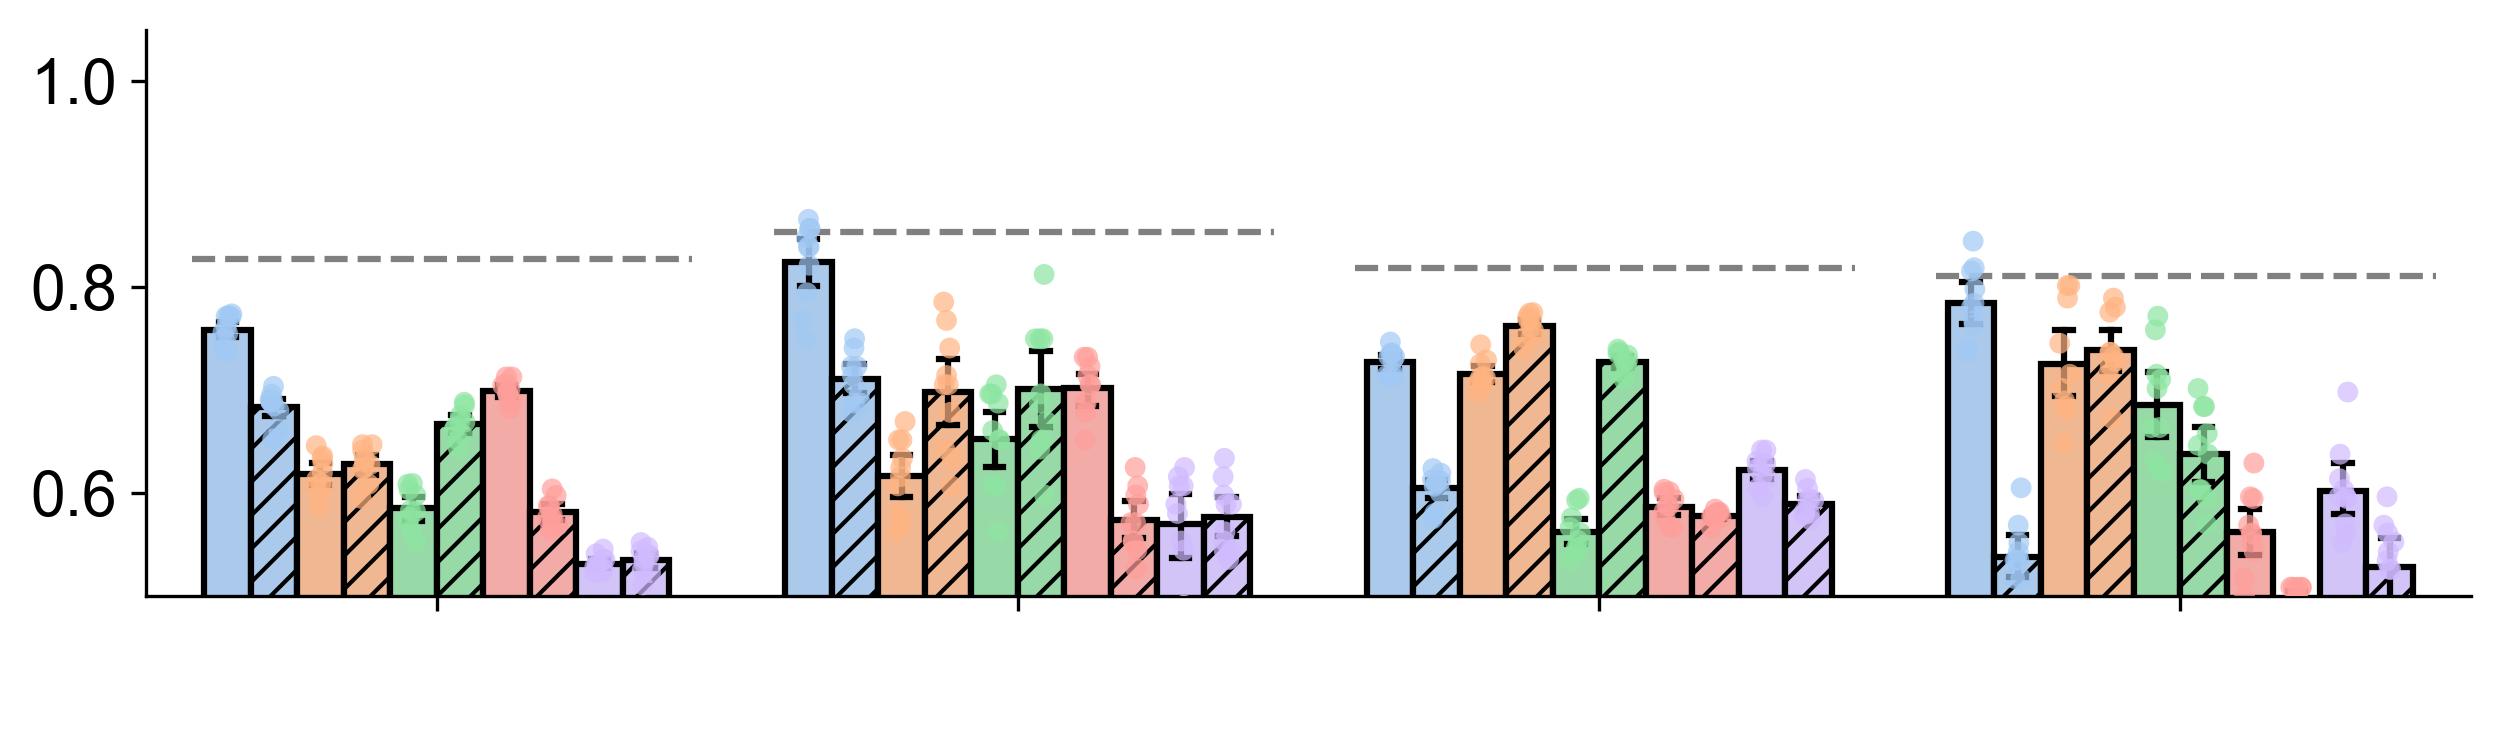

In [13]:

plt.rcParams['font.size'] = 15
df = {'value': [], 'type': [], 'class':[]}

all_acc_lst = [c_acc_lst[0], c_acc_lst[1], c_acc_lst[2], c_acc_lst[3]]
for name, lst in zip(feature_lst, ablation_lst):
    tmp = [lst[0][0], lst[0][1], lst[0][2], lst[0][3]]
    for idx, (res_name, res) in enumerate(zip(model_lst,tmp)):
        c_acc = np.mean(c_acc_lst[idx])
        df['value'].extend(res)
        df['type'].extend([name] * len(res))
        df['class'].extend([res_name] * len(res))


sns.set_context(rc = {'patch.linewidth': 1.5})


fig, ax = plt.subplots(1, 1 , figsize=(10,2.5))
df = pd.DataFrame.from_dict(df)

palette = sns.color_palette("pastel", 5)

palette = [palette[0], palette[0],
           palette[1], palette[1],
           palette[2], palette[2],
           palette[3], palette[3],
           palette[4], palette[4]]


g = sns.barplot(data = df, x='class', y='value', hue='type', ax=ax, 
                errorbar = ('ci', 95),  
                estimator=np.mean, ci=95, capsize=.03, 
                errwidth=1.5, errcolor = 'k', 
                edgecolor = (0,0,0,1), width=0.8,
                palette=palette,
                )
hue_nums = df.groupby("class")["type"].nunique().values
print(hue_nums)


t = all_acc_lst[0]
ax.axhline(y=np.mean(t), xmin=0.02, xmax=0.235,ls='--',c='grey')
t = all_acc_lst[1]
ax.axhline(y=np.mean(t), xmin=0.270, xmax=0.485,ls='--',c='grey')

t = all_acc_lst[2]
ax.axhline(y=np.mean(t), xmin=0.520, xmax=0.735,ls='--',c='grey')
t = all_acc_lst[3]
ax.axhline(y=np.mean(t), xmin=0.770, xmax=0.985,ls='--',c='grey')
g = sns.stripplot(
    data = df,
    x="class", 
    y="value", 
    hue="type", 
    dodge=True, 
    alpha=0.7,
    edgecolor='k', 
    palette=palette,
    ax=ax
)

plt.ylim([-0.0,1.05])
sns.despine(top=True, right=True, left=False, bottom=False)
g.set(ylabel='')
g.set(xlabel='  ')

g.set(ylim=[0.5,1.05])
g.set(ylabel='Proportion')
g.set(xlabel='  ')
g.set(xticklabels=[])

hatches = ['', '', '', '', '///', '///', '///', '///'] * 5

for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])


plt.ylabel("")
plt.xlabel(r"   ")

plt.legend([],[], frameon=False)
